In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("rating2.csv")
df.head()

,users,movies,ratings
0,Lisa Rose,Lady in the Water,2.5
1,Lisa Rose,Snakes on a Plane,3.5
2,Lisa Rose,Just My Luck,3.0
3,Lisa Rose,Superman Returns,3.5
4,Lisa Rose,"You, Me and Dupree",2.5


In [3]:
# Every row is a user and every column is the items. If there are no ratings, leave it as NA
utility_matrix = df.pivot(index="users", columns="movies", values="ratings")
# .fillna(0) Avoid filling with 0, as .corr() skips only N/A or NULL values, but not 0.

# Remove the index to be able to query the table, and also set the 'users' column as the index.
# utility_matrix = utility_matrix.reset_index().rename_axis(None, axis=1)

utility_matrix

movies,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree"
users,,,,,,
Claudia Puig,3.0,NaN,3.5,4.0,4.5,2.5
Gene Seymour,1.5,3.0,3.5,5.0,3.0,3.5
Jack Matthews,NaN,3.0,4.0,5.0,3.0,3.5
Lisa Rose,3.0,2.5,3.5,3.5,3.0,2.5
Michael Phillips,NaN,2.5,3.0,3.5,4.0,NaN
Mick LaSalle,2.0,3.0,4.0,3.0,3.0,2.0
Toby,NaN,NaN,4.5,4.0,NaN,1.0


In [4]:
def recommend(utility_matrix, target, n=5, user_based=True):
    X = utility_matrix
    if user_based:
        X = X.T

    if target not in X.columns:
        return None

    matches = X.corr()[target].sort_values(ascending=False)
    matches = matches.drop(target).head(n)
    return list(zip(matches.index, matches.values))

In [5]:
users = utility_matrix.index
toby = users[6]
recommend(utility_matrix, toby)

[('Lisa Rose', 0.9912407071619305),
 ('Mick LaSalle', 0.924473451641905),
 ('Claudia Puig', 0.8934051474415642),
 ('Jack Matthews', 0.6628489803598702),
 ('Gene Seymour', 0.3812464258315117)]

In [6]:
items = utility_matrix.columns
superman_returns = items[3]
recommend(utility_matrix, superman_returns, user_based=False)

[('You, Me and Dupree', 0.6579516949597688),
 ('Lady in the Water', 0.48795003647426655),
 ('Snakes on a Plane', 0.11180339887498938),
 ('The Night Listener', -0.1798471947990542),
 ('Just My Luck', -0.4228900316110311)]

In [7]:
utility_matrix.T.corr()

users,Claudia Puig,Gene Seymour,Jack Matthews,Lisa Rose,Michael Phillips,Mick LaSalle,Toby
users,,,,,,,
Claudia Puig,1.000000,0.314970,0.028571,0.566947,1.000000,0.566947,0.893405
Gene Seymour,0.314970,1.000000,0.963796,0.396059,0.204598,0.411765,0.381246
Jack Matthews,0.028571,0.963796,1.000000,0.747018,0.134840,0.211289,0.662849
Lisa Rose,0.566947,0.396059,0.747018,1.000000,0.404520,0.594089,0.991241
Michael Phillips,1.000000,0.204598,0.134840,0.404520,1.000000,-0.258199,-1.000000
Mick LaSalle,0.566947,0.411765,0.211289,0.594089,-0.258199,1.000000,0.924473
Toby,0.893405,0.381246,0.662849,0.991241,-1.000000,0.924473,1.000000


In [8]:
def top_matches(utility_matrix, idx, n=5, debug=False):
    corr = utility_matrix.corr()
    columns = corr.T.index  # Note that the column is transposed.

    if debug:
        print("Similar movies for: {}\n".format(columns[idx]))
        print(corr[columns[idx]].sort_values(ascending=False))

    matches = columns[corr[columns[idx]].values.argsort()[::-1]].tolist()

    # Remove the current target to match the recommendation against.
    matches.remove(columns[idx])

    return columns[idx], matches[:n]

In [9]:
target, matches = top_matches(utility_matrix.T, 6, debug=True)
print("\nSimilar users to {}:".format(target))
for i, user in enumerate(matches):
    print("{}. {}".format(i + 1, user))

Similar movies for: Toby

users
Toby                1.000000
Lisa Rose           0.991241
Mick LaSalle        0.924473
Claudia Puig        0.893405
Jack Matthews       0.662849
Gene Seymour        0.381246
Michael Phillips   -1.000000
Name: Toby, dtype: float64

Similar users to Toby:
1. Lisa Rose
2. Mick LaSalle
3. Claudia Puig
4. Jack Matthews
5. Gene Seymour


In [10]:
target, matches = top_matches(utility_matrix, 3, debug=True)
print("\nSimilar movies to {}:".format(target))
for i, user in enumerate(matches):
    print("{}. {}".format(i + 1, user))

Similar movies for: Superman Returns

movies
Superman Returns      1.000000
You, Me and Dupree    0.657952
Lady in the Water     0.487950
Snakes on a Plane     0.111803
The Night Listener   -0.179847
Just My Luck         -0.422890
Name: Superman Returns, dtype: float64

Similar movies to Superman Returns:
1. You, Me and Dupree
2. Lady in the Water
3. Snakes on a Plane
4. The Night Listener
5. Just My Luck


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Text(0.5, 1.0, 'Similar users')

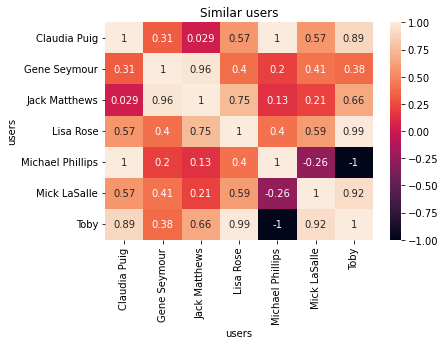

In [12]:
sns.heatmap(utility_matrix.T.corr(), annot=True)
plt.title("Similar users")

Text(0.5, 1.0, 'Similar movies')

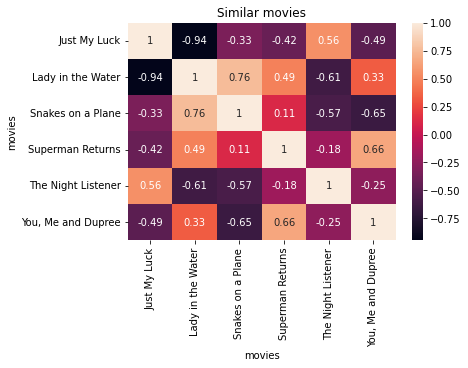

In [13]:
sns.heatmap(utility_matrix.corr(), annot=True)
plt.title("Similar movies")

In [14]:
from sklearn.decomposition import NMF, TruncatedSVD

# TruncatedSVD does not deal with missing data, and setting it to 0 is not accurate.
X = utility_matrix.fillna(0)
model = TruncatedSVD(n_components=5, random_state=0)
decomposed_matrix = model.fit_transform(X)

In [15]:
X.shape

(7, 6)

In [16]:
idx = 6
X.index[idx]

'Toby'

In [17]:
import numpy as np

# Correlation matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(7, 7)

In [18]:
pd.DataFrame(
    {
        "movies": X.index,
        "score": correlation_matrix[idx],
    }
).sort_values(by="score", ascending=False)

,movies,score
6,Toby,1.000000
2,Jack Matthews,0.911225
1,Gene Seymour,0.873213
3,Lisa Rose,0.714913
5,Mick LaSalle,0.711393
0,Claudia Puig,0.654700
4,Michael Phillips,0.607303


Similar users to Toby:

1. Lisa Rose
2. Mick LaSalle
3. Claudia Puig
4. Jack Matthews
5. Gene Seymour

In [19]:
# Matrix Factorization
# NMF does not deal with missing data, and setting it to 0 is not accurate.
# https://github.com/scikit-learn/scikit-learn/issues/8447
# The solution is to drop those with NA, but that's not what we want to achieve since we want to predict the ratings with matrix factorization.
X = utility_matrix.fillna(0)
model = NMF(n_components=X.shape[0], init="random", random_state=0)
W = model.fit_transform(X)
H = model.components_
nR = np.dot(W, H)
nR

array([[2.99992519e+00, 1.63004041e-04, 3.49995716e+00, 4.00046684e+00,
        4.49997688e+00, 2.50015944e+00],
       [1.49985882e+00, 3.00000747e+00, 3.50003258e+00, 4.99992248e+00,
        3.00003259e+00, 3.50006241e+00],
       [5.22969211e-06, 3.00003230e+00, 3.99994427e+00, 4.99988801e+00,
        3.00002924e+00, 3.50001314e+00],
       [2.99997763e+00, 2.49995313e+00, 3.50009691e+00, 3.50021056e+00,
        3.00003544e+00, 2.49992782e+00],
       [2.29103417e-07, 2.50016001e+00, 2.99993601e+00, 3.49937928e+00,
        4.00013175e+00, 4.51301577e-03],
       [2.00015391e+00, 2.99986324e+00, 3.99999153e+00, 3.00048013e+00,
        3.00000121e+00, 1.99980952e+00],
       [5.07410523e-05, 3.11260092e-04, 4.50003321e+00, 3.99968809e+00,
        3.11251638e-04, 9.99879961e-01]])

In [20]:
X.index[nR[idx].argsort()[::-1]]

Index(['Jack Matthews', 'Lisa Rose', 'Mick LaSalle', 'Gene Seymour',
       'Michael Phillips', 'Claudia Puig'],
      dtype='object', name='users')

In [21]:
# TODO: Check surprise matrix factorization.
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html

In [22]:
nR = np.dot(W[idx], H)
X.index[nR.argsort()[::-1]]

Index(['Jack Matthews', 'Lisa Rose', 'Mick LaSalle', 'Gene Seymour',
       'Michael Phillips', 'Claudia Puig'],
      dtype='object', name='users')

In [23]:
W[idx]

array([3.44166086e-04, 0.00000000e+00, 0.00000000e+00, 1.60906273e+00,
       0.00000000e+00, 3.00694404e+00, 0.00000000e+00])

In [24]:
# Since we have "learned" the latent features through SVD, we can now generate ratings and find similar users to existing user pool.
print("Ratings for ", X.columns)
nR = np.dot([4, 0, 0, 2, 0, 3, 0], H)
X.index[nR.argsort()[::-1]]

Ratings for  Index(['Just My Luck', 'Lady in the Water', 'Snakes on a Plane',
       'Superman Returns', 'The Night Listener', 'You, Me and Dupree'],
      dtype='object', name='movies')


Index(['Lisa Rose', 'Jack Matthews', 'Mick LaSalle', 'Gene Seymour',
       'Michael Phillips', 'Claudia Puig'],
      dtype='object', name='users')